In [1]:
import sys
!{sys.executable} -m pip install Rpy2 pandas yfinance sklearn matplotlib statsmodels yahoofinancials


distutils: /mnt/distvol/Python-3.9.4/include/python3.9/UNKNOWN
sysconfig: /mnt/distvol/Python-3.9.4/include/python3.9
user = False
home = None
root = None
prefix = None
distutils: /mnt/distvol/Python-3.9.4/include/python3.9/UNKNOWN
sysconfig: /mnt/distvol/Python-3.9.4/include/python3.9
user = False
home = None
root = None
prefix = None


In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as R
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from yahoofinancials import YahooFinancials
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

Stock = yf.download('GOLD', 
                      start='2013-01-01', 
                      end='2019-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 

#all_data = Stock[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data = pd.read_csv('/mnt/distvol/re_fixed_multivariate_timeseries.csv').set_index('datetime')
#all_data = all_data.filter(['GBP/mWh','temperature','coal Price','oil Price','uranium Price','natural gas Price'])

#all_data['return'] = all_data['Adj Close'].pct_change()

#all_data = all_data.filter(['return','Adj Close','Open','High','Low','Close','Volume']).dropna()
all_data[23:47]
#all_data['Adj Close'].plot()
# There are 1,510 and 251 observations in the training and test data respectively.

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
datetime,,,,,,
2013-01-02 00:00:00,34.96,40.11,95.67,112.47,43.25,3.233
2013-01-02 01:00:00,31.31,40.91,95.67,112.47,43.25,3.233
2013-01-02 02:00:00,28.91,39.45,95.67,112.47,43.25,3.233
2013-01-02 03:00:00,28.03,38.71,95.67,112.47,43.25,3.233
2013-01-02 04:00:00,25.81,38.70,95.67,112.47,43.25,3.233
2013-01-02 05:00:00,30.08,38.60,95.67,112.47,43.25,3.233
2013-01-02 06:00:00,55.01,38.52,95.67,112.47,43.25,3.233
2013-01-02 07:00:00,39.09,39.94,95.67,112.47,43.25,3.233
2013-01-02 08:00:00,44.08,40.78,95.67,112.47,43.25,3.233


In [3]:
from datetime import datetime
all_data.index = pd.to_datetime(all_data.index)
#all_data.resample('D')


In [4]:
daily_all_data = all_data.resample('D').mean().dropna()

In [5]:
R.r('''
           f <- function(values) {
                    #system("which openssl")

                    library(snpEnrichment)
                    library(arfima)
                    library(parallel)
                    library(forecast)                    
                    
                    dset <- mclapply(1:ncol(values),function(x)
                    {
                        column = values[,x]
                        
                        
                        #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                        #{
                          varvefd = arfima(column)
                          d = summary(varvefd)$coef[[1]][1]
                          return(d)
                        #}
                       #)
                       #))),
                        #error=function(e)
                          #{
                            #d = 1
                            #return(d)
                          #})
                    
                    })    
                    
                    unlist(dset)

            }
            ''')

r_f = R.globalenv['f']
d=R.conversion.rpy2py((r_f(R.conversion.py2rpy(daily_all_data.dropna()))))


R[write to console]: Loading required package: ltsa

R[write to console]: Note that the arfima package has new defaults starting with
1.4-0: type arfimachanges() for a list, as well as some other notes.
NOTE: some of these are quite important!

R[write to console]: 
Attaching package: ‘arfima’


R[write to console]: The following object is masked from ‘package:stats’:

    BIC


R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: 
Attaching package: ‘forecast’


R[write to console]: The following object is masked from ‘package:arfima’:

    arfima




In [24]:

def ts_train_test_normalize(all_data,time_steps,for_periods, n_features):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set

    #n_features = 1
            
    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import QuantileTransformer
    from sklearn.model_selection import train_test_split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    trainOuter, test = train_test_split(all_data, test_size=0.33, shuffle=False)
    trainInner, valid = train_test_split(trainOuter, test_size=0.33, shuffle=False)
    
    #sc = MinMaxScaler()
    #sc = RobustScaler()
    #sc = Normalizer()
    sc = QuantileTransformer(output_distribution='normal')
    #sc = StandardScaler()
    
    #transform each range to scale
    
    #sc.fit(all_data[(all_data.index<'2019')].iloc[:,0:n_features])
    sc.fit(trainOuter)
    
    #transform each range to scale
    
    #s_train_scaled = all_data[(all_data.index<'2017')].iloc[:,0:n_features].values
    #ts_train_scaled = sc.transform(all_data[(all_data.index<='2017')].iloc[:,0:n_features])    
    ts_train_scaled = sc.transform(trainInner)    
    #ts_valid_scaled = all_data[(all_data.index>='2017')&(all_data.index<'2019')].iloc[:,0:n_features].values
    #ts_valid_scaled = sc.transform(all_data[(all_data.index>'2017')&(all_data.index<'2019')].iloc[:,0:n_features])
    ts_valid_scaled = sc.transform(valid)
    #ts_test_scaled  = all_data[(all_data.index>='2019')].iloc[:,0:n_features].values
    #ts_test_scaled  = sc.transform(all_data[(all_data.index>='2019')].iloc[:,0:n_features])
    ts_test_scaled  = sc.transform(test)
    
    #new_series = pd.DataFrame(all_data[:'2017'].iloc[:,0:n_features].values).append(pd.DataFrame(all_data['2017':'2018'].iloc[:,0:n_features].values),ignore_index=True).append(pd.DataFrame(all_data['2019':].iloc[:,0:n_features].values),ignore_index=True)
    new_series = pd.DataFrame(ts_train_scaled).append(pd.DataFrame(ts_valid_scaled)).append(pd.DataFrame(ts_test_scaled))
    
    series_reshaped = np.array([new_series[i:i + (n_steps+n_ahead)].copy() for i in range(len(all_data) - (n_steps+n_ahead))])        
    
    X_train = series_reshaped[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    X_valid = series_reshaped[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    X_test = series_reshaped[-len(ts_test_scaled)+2:,:n_steps]
    
    Y = np.empty(((len(all_data) - n_steps - n_ahead), n_steps, n_ahead))  
    
    for step_ahead in range(1, n_ahead + 1):     
       Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]

    Y_train = Y[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    Y_valid = Y[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    Y_test = Y[-len(ts_test_scaled)+2:,:n_steps]
    
    #print(ts_train_scaled)
    return X_train, Y_train, X_valid, Y_valid, X_test, sc

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

def return_actual(model, sc):

    Y_pred = model6.predict(X_test)

    last_list=[]

    for i in range (0, len(Y_pred)):
      last_list.append((Y_pred[i][0][n_ahead-1]))

    actual = pd.DataFrame((sc.inverse_transform(X_test[:,0])))
    #actual = pd.DataFrame(((X_test[:,0])))
    actual.rename(columns = {0:'actual'}, inplace = True)
    actual['predictions'] = last_list
    #actual['predictions'] = invTransform(sc,actual["predictions"],"Adj Close",all_data.columns)
    actual['predictions'] = invTransform(sc,actual["predictions"],all_data.columns[0],all_data.columns)
    actual['difference'] = (actual['predictions'] - actual['actual']).abs()
    actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
    
    return(actual)

# - scaler   = the scaler object (it needs an inverse_transform method)
# - data     = the data to be inverse transformed as a Series, ndarray, ... 
#              (a 1d object you can assign to a df column)
# - ftName   = the name of the column to which the data belongs
# - colNames = all column names of the data on which scaler was fit 
#              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


In [7]:
def get_weights(d, num_k):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
    """
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        
        k += 1

    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def frac_diff(df, d, floor=1e-3):
    r"""Fractionally difference time series via CPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        date_idx = df.index[idx]
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    # Return FD values and weights
    df_fd = pd.DataFrame(df_fd)
    
    return df_fd, weights

In [8]:

from fracdiff import fdiff

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED

cores = int(len(os.sched_getaffinity(0)))

def getDifferenced(i):
    #v = d[[i]]
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i], d=d[[i]], floor=5e-5)
    
    a = np.array(daily_all_data.iloc[:, i])
    
    return fdiff(a, n=d[i], axis=0)
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i]), d=v, floor=5e-5)

pool01 = concurrent.futures.ProcessPoolExecutor(cores)

futures01 = [pool01.submit(getDifferenced, args) for args in range(0,len(d))]

wait(futures01, timeout=None, return_when=ALL_COMPLETED)


DoneAndNotDoneFutures(done={<Future at 0x7f274132f250 state=finished returned ndarray>, <Future at 0x7f274132f490 state=finished returned ndarray>, <Future at 0x7f274132f0d0 state=finished returned ndarray>, <Future at 0x7f274132f370 state=finished returned ndarray>, <Future at 0x7f274132f580 state=finished returned ndarray>, <Future at 0x7f274131b1f0 state=finished returned ndarray>}, not_done=set())

In [9]:
daily_all_data.describe()

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,45.544870,53.469054,75.892142,71.081418,29.704445,3.114865
std,9.336876,9.938309,15.891444,23.745737,6.718934,0.725076
min,26.495000,25.803750,39.948750,27.937083,17.760417,1.640125
25%,39.188452,46.010833,64.252500,52.367500,24.450000,2.660000
50%,44.075208,53.121875,77.750000,63.655000,28.300000,2.939000
75%,50.285938,61.262813,87.508750,93.633438,35.750000,3.587219
max,170.150000,85.722083,111.160000,118.900000,44.000000,6.149000


In [10]:

Differenced_Set = pd.DataFrame()
for f in range(0,len(futures01)):
    value = pd.DataFrame(futures01[f].result())
    Differenced_Set = pd.concat([Differenced_Set,value],axis=1)
    
Differenced_Set.columns = daily_all_data.columns

In [11]:
Differenced_Set.describe()

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,11.332325,11.569321,14.137505,13.242715,5.531955,0.580569
std,5.251125,4.014376,3.571414,5.040954,1.542967,0.168636
min,-33.190674,-4.325323,3.875506,3.236182,2.445479,0.195103
25%,8.937950,8.899657,11.808611,9.708360,4.471938,0.475038
50%,10.885139,11.672153,14.392840,11.987133,5.279299,0.549705
75%,13.192048,14.244269,16.246155,16.660972,6.623822,0.671894
max,139.285502,43.460870,95.590000,111.110000,43.500000,3.351000


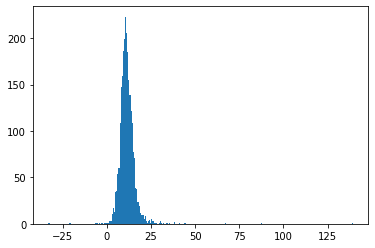

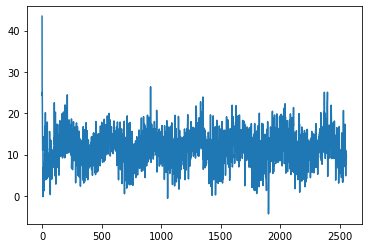

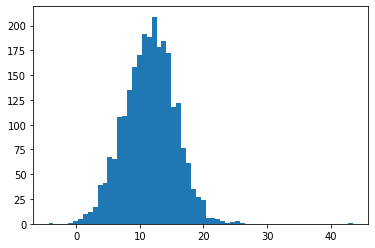

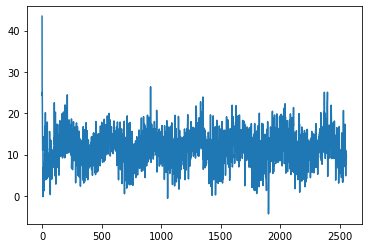

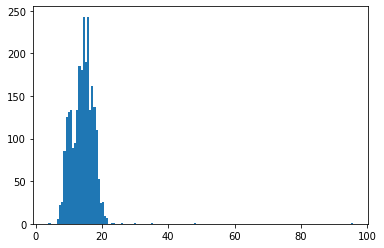

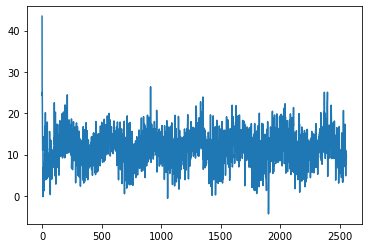

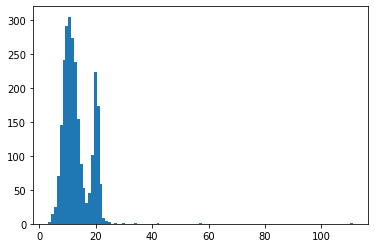

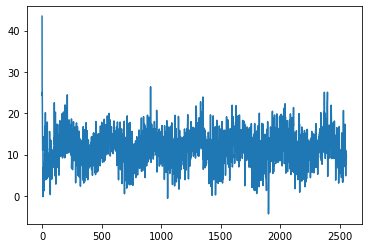

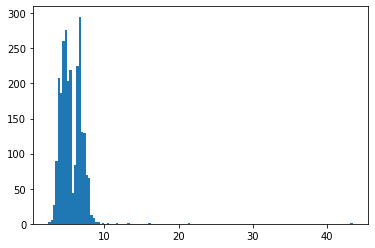

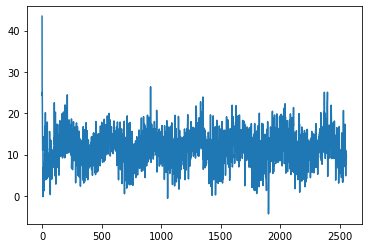

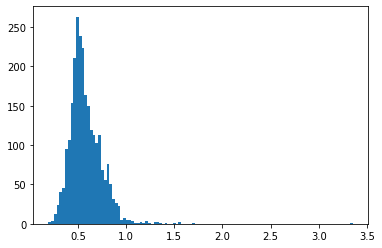

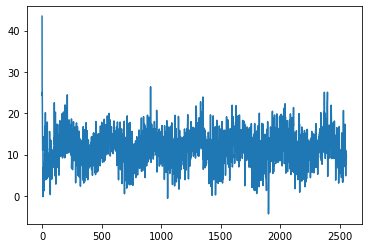

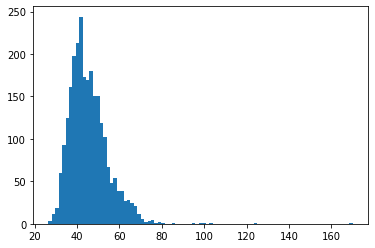

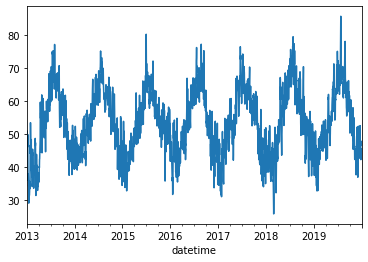

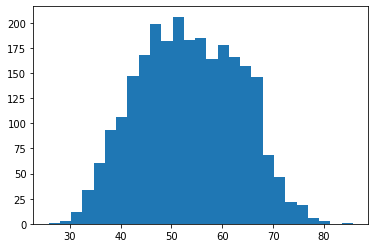

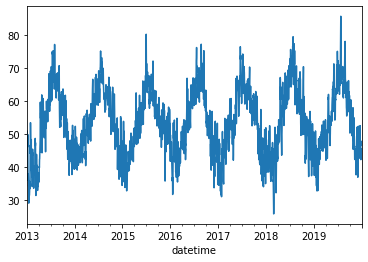

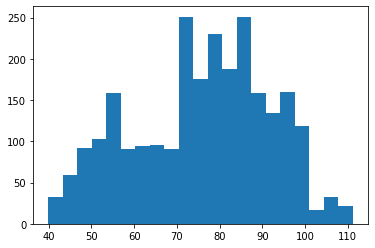

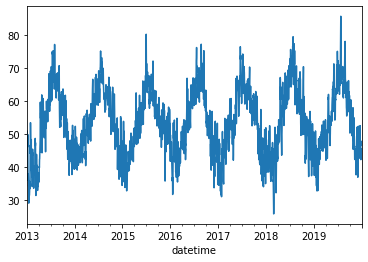

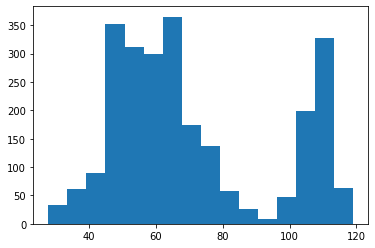

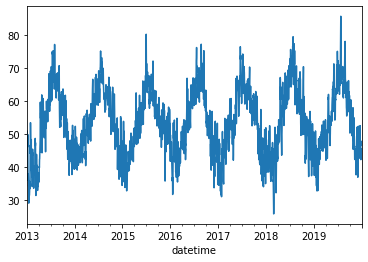

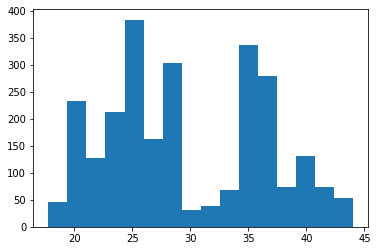

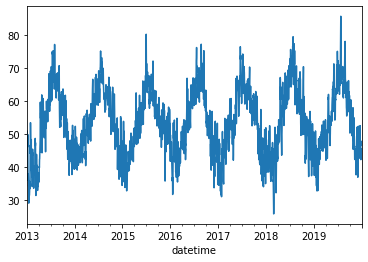

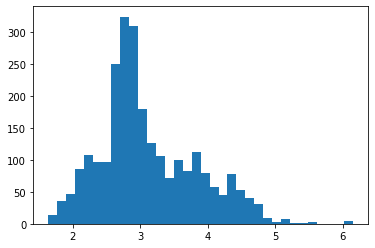

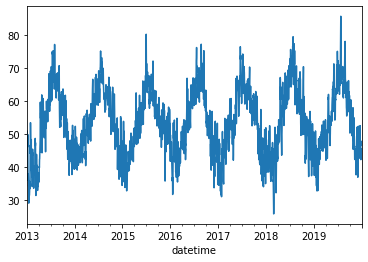

In [12]:

for f in range(0,len(futures01)):
    #print(f)
    #print(len(futures01[f].result()))
    plt.hist(Differenced_Set.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
    plt.show()
    Differenced_Set.iloc[:,1].plot()
    plt.show()
    
for f in range(0,len(daily_all_data.columns)):
    #print(f)
    #print(len(futures01[f].result()))
    plt.hist(daily_all_data.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
    plt.show()
    daily_all_data.iloc[:,1].plot()
    plt.show()

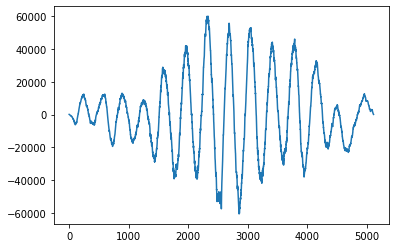

-222


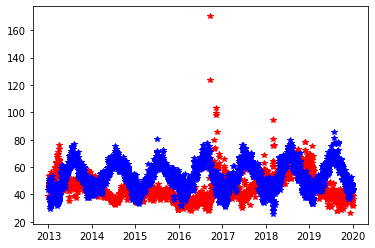

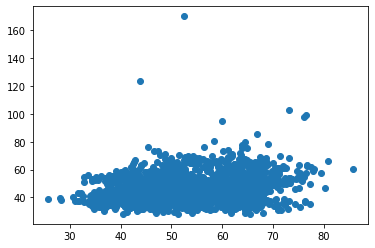

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


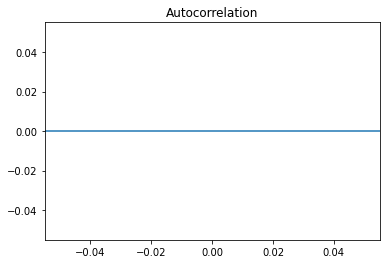

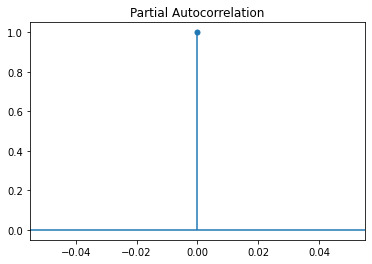

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                          2.603e+04
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                        0.00
Time:                        15:24:34   Log-Likelihood:                         -10354.
No. Observations:                2556   AIC:                                  2.071e+04
Df Residuals:                    2555   BIC:                                  2.072e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

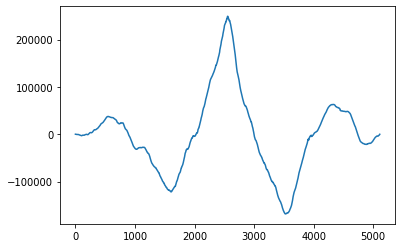

0


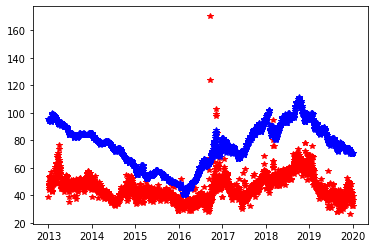

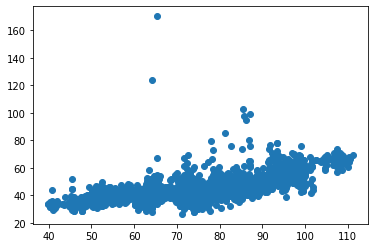

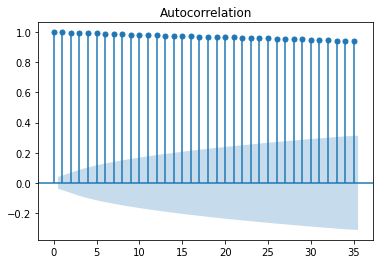

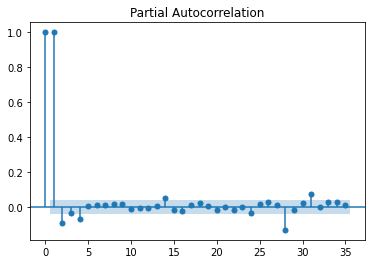

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          8.862e+04
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                        0.00
Time:                        15:24:34   Log-Likelihood:                         -8871.4
No. Observations:                2556   AIC:                                  1.774e+04
Df Residuals:                    2555   BIC:                                  1.775e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

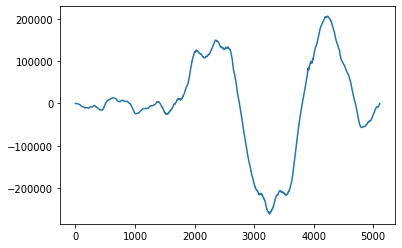

1677


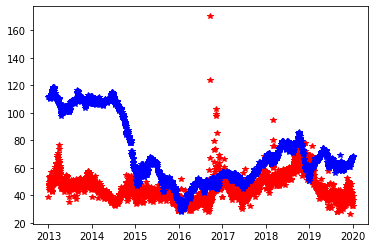

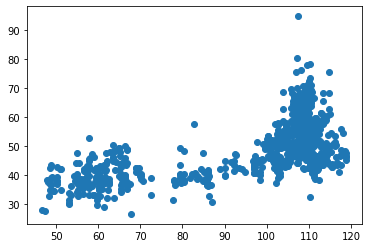

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


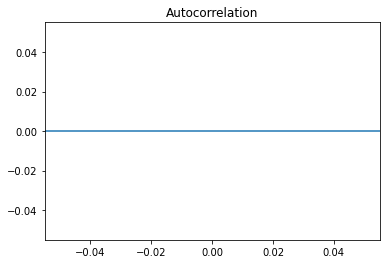

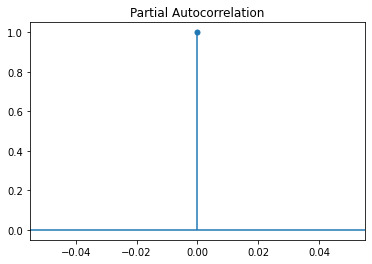

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                          2.091e+04
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                        0.00
Time:                        15:24:35   Log-Likelihood:                         -10606.
No. Observations:                2556   AIC:                                  2.121e+04
Df Residuals:                    2555   BIC:                                  2.122e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

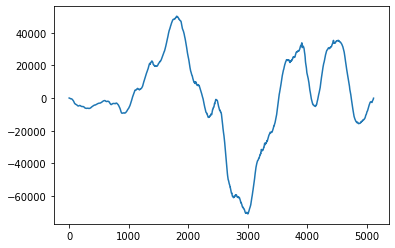

-750


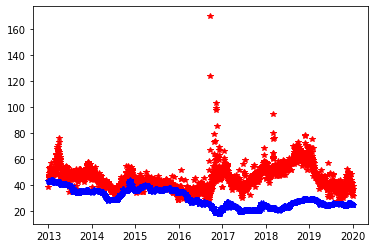

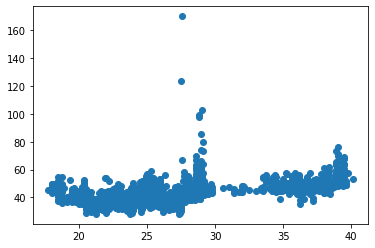

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


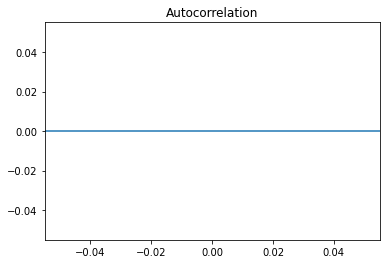

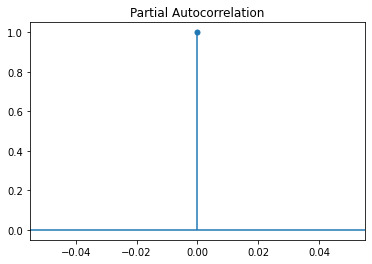

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                          2.520e+04
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                        0.00
Time:                        15:24:36   Log-Likelihood:                         -10392.
No. Observations:                2556   AIC:                                  2.079e+04
Df Residuals:                    2555   BIC:                                  2.079e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

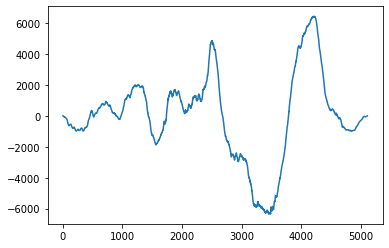

1661


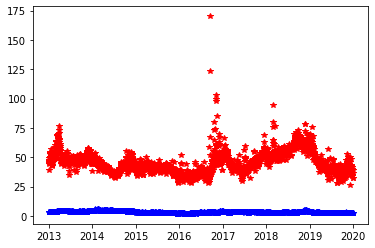

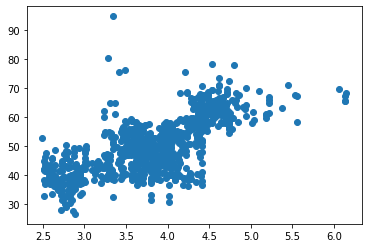

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


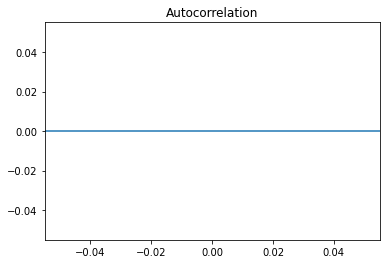

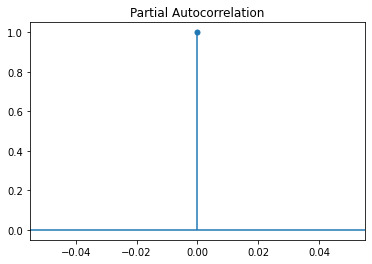

                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                          3.490e+04
Date:                Tue, 27 Apr 2021   Prob (F-statistic):                        0.00
Time:                        15:24:36   Log-Likelihood:                         -10008.
No. Observations:                2556   AIC:                                  2.002e+04
Df Residuals:                    2555   BIC:                                  2.002e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

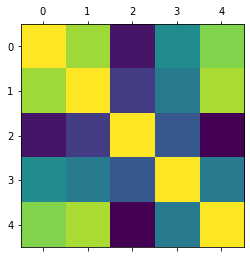

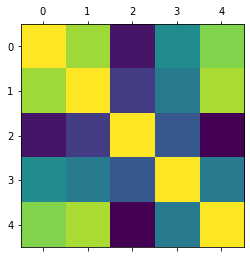

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     75.10
Date:                Tue, 27 Apr 2021   Prob (F-statistic):           3.33e-32
Time:                        15:24:37   Log-Likelihood:                -394.72
No. Observations:                 129   AIC:                             799.4
Df Residuals:                     124   BIC:                             813.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.8742     35.309      0.223      0.824     -62.013      77.761
coal Price            2.1027      0.223      9.445      0.000       1.662       2.543
oil Price            -0.9418      0.145     -6.517      0.000      -1.228      -0.656
uranium Price         0.1018      0.895      0.114      0.910      -1.670       1.874
natural gas Price    -8.1605      2.897     -2.816      0.006     -13.895      -2.426
==============================================================================
Omnibus:                        1.243   Durbin-Watson:                   0.572
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                0.867
Skew:                           0.181   Prob(JB):                        0.648
Kurtosis:                       3.173   Cond. No.                     1.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
from scipy import signal
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  #for plotting purpose
from sklearn import linear_model   #for implementing multiple linear regression
import statsmodels.api as sm
#corr = signal.correlate(sig_noise, np.ones(128), mode='same') / 128

#set = Differenced_Set
set = daily_all_data

Lagged_Differenced_Set = pd.DataFrame()
Lagged_Set = pd.DataFrame()

for f in range(1,len(set.columns)):
    #print(f)
    #print(len(futures01[f].result()))
        
    data_1 = set.iloc[:,0]
    data_2 = set.iloc[:,f]

    corr = np.correlate(data_1 - np.mean(data_1), 
                        data_2 - np.mean(data_2),
                        mode='full')
    plt.plot(corr)
    plt.show()
    lag = corr.argmax() - (len(data_1) - 1)
    print(lag)
    plt.plot(data_1, 'r*')
    plt.plot(data_2, 'b*')
    plt.show()

    plt.scatter(data_2.shift(lag),data_1)
    plt.show()
    
    plot_acf(data_2.shift(lag))
    plt.show()
    
    plot_pacf(data_2.shift(lag))
    plt.show()

    y = data_1
    X = data_2
    #reg = LinearRegression().fit(X, y)

    #print(reg.score(X, y),reg.coef_,reg.intercept_)

    model = sm.OLS(y,X)
    results = model.fit()
    print(results.summary())
    
    Lagged_Differenced_Set = pd.concat([Lagged_Differenced_Set,data_2.shift(lag)],axis=1)
    Lagged_Set = pd.concat([Lagged_Set,data_2.shift(lag)],axis=1)
    
Lagged_Differenced_Set = Lagged_Differenced_Set.dropna()    

Lagged_Set=Lagged_Set.dropna()

X=Lagged_Set.iloc[:,1:]
Y=Lagged_Set.iloc[:,0]
reg=LinearRegression()     #initiating linearregression
reg.fit(X,Y)
Intercept=reg.intercept_
Coefficients=reg.coef_

plt.matshow(Lagged_Set.corr())
plt.show()

plt.matshow(Lagged_Differenced_Set.corr())
plt.show()

X=sm.add_constant(X)        #to add constant value in the model
model= sm.OLS(Y,X).fit()         #fitting the model
predictions= model.summary()      #summary of the model
predictions



In [14]:
from sklearn.utils import as_float_array
from sklearn.base import TransformerMixin, BaseEstimator

class ZCA(BaseEstimator, TransformerMixin):

    def __init__(self, regularization=1e-5, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        X = as_float_array(X, copy=self.copy)
        self.mean_ = np.mean(X, axis=0)
        X = X - self.mean_
        sigma = np.dot(X.T, X) / (X.shape[0] - 1)
        U, S, V = np.linalg.svd(sigma)
        tmp = np.dot(U, np.diag(1 / np.sqrt(S + self.regularization)))
        self.components_ = np.dot(tmp, U.T)
        return self

    def transform(self, X):
        X_transformed = X - self.mean_
        X_transformed = np.dot(X_transformed, self.components_.T)
        return X_transformed

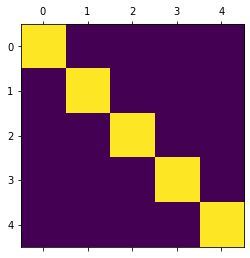

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                 3.095e-10
Date:                Tue, 27 Apr 2021   Prob (F-statistic):               1.00
Time:                        15:24:37   Log-Likelihood:                -182.54
No. Observations:                 129   AIC:                             375.1
Df Residuals:                     124   BIC:                             389.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.96e-15      0.089  -3.31e-14      1.000      -0.177       0.177
1           7.836e-07      0.090   8.73e-06      1.000      -0.178       0.178
2           -3.51e-07      0.090  -3.91e-06      1.000      -0.178       0.178
3           3.795e-08      0.090   4.23e-07      1.000      -0.178       0.178
4          -3.041e-06      0.090  -3.39e-05      1.000      -0.178       0.178
==============================================================================
Omnibus:                        5.274   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.891
Skew:                          -0.469   Prob(JB):                       0.0867
Kurtosis:                       3.171   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#from zca import ZCA
zca = ZCA()

data_zca = pd.DataFrame(zca.fit_transform(Lagged_Set))

X=data_zca.iloc[:,1:]
Y=data_zca.iloc[:,0]
reg=LinearRegression()     #initiating linearregression
reg.fit(X,Y)
Intercept=reg.intercept_
Coefficients=reg.coef_

plt.matshow(data_zca.corr())
plt.show()

X=sm.add_constant(X)        #to add constant value in the model
model= sm.OLS(Y,X).fit()         #fitting the model
predictions= model.summary()      #summary of the model
predictions


In [16]:
data_zca.describe()
#data_zca.set_index(Lagged_Set.index)

,0,1,2,3,4
count,1.290000e+02,1.290000e+02,1.290000e+02,1.290000e+02,1.290000e+02
mean,-2.974365e-15,1.038274e-14,7.711317e-16,4.716296e-16,-8.592610e-15
std,9.999998e-01,9.999980e-01,9.999994e-01,9.999815e-01,9.997937e-01
min,-2.905149e+00,-2.312556e+00,-2.287634e+00,-2.376270e+00,-1.977783e+00
25%,-5.937049e-01,-8.889891e-01,-6.676532e-01,-4.868178e-01,-7.947193e-01
50%,5.247123e-02,-4.150657e-02,-2.212296e-02,1.694639e-02,-1.510485e-01
75%,7.368031e-01,7.754609e-01,4.780983e-01,7.471608e-01,6.744706e-01
max,2.023372e+00,2.519896e+00,2.527389e+00,1.814836e+00,2.900415e+00


In [17]:
n_steps = 21
n_ahead = 1
n_features = len(data_zca.columns)

X_train, Y_train, X_valid, Y_valid, X_test, asc = ts_train_test_normalize(all_data.resample('D').mean(),n_steps,n_ahead,n_features)
#X_train, Y_train, X_valid, Y_valid, X_test, sc = ts_train_test_normalize(data_zca.set_index(Lagged_Set.index),n_steps,n_ahead,n_features)
print(X_train.shape[0],X_train.shape[1],X_train.shape[2])
print(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2])
print(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2])
print(Y_valid.shape[0],Y_valid.shape[1],Y_valid.shape[2])
print(X_test.shape[0],X_test.shape[1],X_test.shape[2])

1127 21 6
1127 21 1
565 21 6
565 21 1
842 21 6


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
epochs_ = 100
batch_size_ = 150

np.random.seed(42)
tf.random.set_seed(42)

from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD

#simple RNN

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(all_data.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model6.compile(loss="mean_squared_error", optimizer="rmsprop",metrics=['mean_squared_error'])
history = model6.fit(X_train, Y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, Y_valid))


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Epoch 1/100
8/8 [==============================] - 2s 54ms/step - loss: 0.9436 - mean_squared_error: 0.9436 - val_loss: 0.7017 - val_mean_squared_error: 0.7017
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.2220 - mean_squared_error: 0.2220 - val_loss: 0.6420 - val_mean_squared_error: 0.6420
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.6087 - val_mean_squared_error: 0.6087
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1453 - mean_squared_error: 0.1453 - val_loss: 0.5689 - val_mean_squared_error: 0.5689
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.5735 - val_mean_squared_error: 

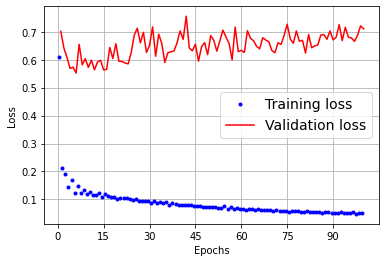

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [1023]:
np.random.seed(42)
tf.random.set_seed(42)

#GRU with regularization
'''
model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, len(all_data.columns)]),
    
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),

    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

#model10.compile(loss="mape", optimizer="adam")
model10.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss='mean_squared_error')
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=batch_size_,
                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])
'''

'\nmodel10 = keras.models.Sequential([\n    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",\n                        input_shape=[None, len(all_data.columns)]),\n    \n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n\n    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))\n])\n\n#model10.compile(loss="mape", optimizer="adam")\nmodel10.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss=\'mean_squared_error\')\nhistory2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=batch_size_,\n                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])\n'

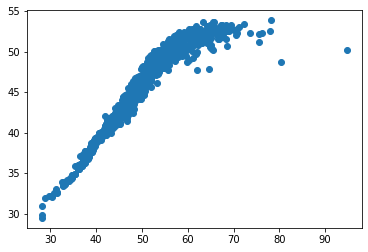

In [25]:
actual = return_actual(model6, asc)

plt.scatter(actual["actual"],actual["predictions"])

In [26]:
from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(actual["actual"], actual["predictions"], squared=True)
rmse2 = mean_squared_error(actual["actual"].shift(-1).dropna(), actual["predictions"][0:len(actual["actual"].shift(-1).dropna())], squared=True)
rmse1-rmse2

-5.828280894003832

0     -0.575004
1     -0.689574
2     -0.589204
3     -0.410082
4     -0.360000
         ...   
244   -0.330000
245   -0.286614
246   -0.288200
247   -0.404334
248   -0.390000
Length: 249, dtype: float64

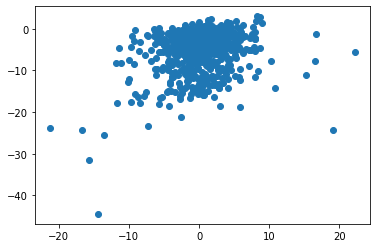

In [27]:
plt.scatter(actual["actual"].shift(1)-actual["actual"],actual["predictions"]-actual["actual"])


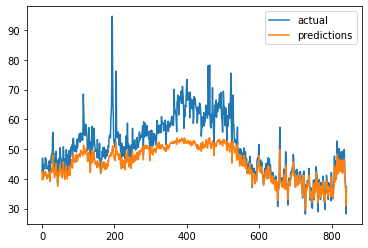

In [28]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()